# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from numpy.random import seed
medical = pd.read_csv('./insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [4]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

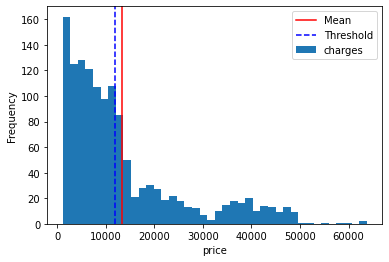

In [339]:
medical.charges.plot(kind='hist',bins=40,label=None)

plt.axvline(medical.charges.mean(), color='r',linestyle='-',label='Mean')
plt.axvline(12_000, color='b',linestyle='--',label='Threshold')

plt.xlabel('price')
plt.legend();

In [16]:
medical.charges.mean()

13270.422265141257

In [18]:
medical.charges.std()

12110.011236693994

The distribution is not symmetric and has a pretty complicated structure (a steep falling for low charges, and a few bumps at higher charges, most probably related to various differently-priced services). The Gaussian function is not approperiate for describing complex, highly asymmetric problems, and this is reflected here by a very large value of std.

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ If the mean is the only parameter than the administrator is interested in, I would go ahead and use the bootstraping and the CLT to estimate the distribution of the true mean. That will allow us to calculate the p value of the administrator's nightmare that the average price is below $12k.

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__ A priori, we don't know if the average price is below or above the operational threshold of \\$12k, so both options are possible and the two-sided interval should be considered. This gives a more conservative approach, e.g. for the price being above the threshold, the margin of error will be closer to the threshold (at the value where the first 2.5\%, instead of 5\%, of the true mean population reside). However, we can also directly calculate the p value of the "below \$12k" hypothesis, using the true mean spectrum as the null hypothesis distribution.

13272.711568672625 331.5422642842205


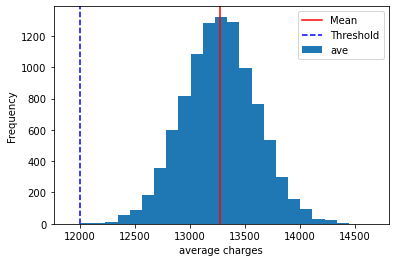

In [162]:
# let's bootstrap to get the true mean statistics 
# (= normal distribution with the width fixed by 1338 entries in the input sample)
#
# number of trials
n = 10_000
bs = medical.charges

seed(1)
bs_mean = pd.DataFrame({'ave': [bs.sample(bs.shape[0],replace=True).mean() for i in range(n)]})

print(bs_mean.ave.mean(),bs_mean.ave.std())

bs_mean.plot(kind='hist',bins=25,legend=None)
plt.axvline(bs_mean.ave.mean(), color='r',linestyle='-',label='Mean')
plt.axvline(12_000, color='b',linestyle='--',label='Threshold')
plt.xlabel('average charges')
plt.legend();

95\% confidence interval for the true mean is:

In [96]:
cl = t.ppf([0.025,0.975],bs.shape[0]-1,np.mean(bs_mean),np.std(bs_mean,ddof=1))
print(np.round(cl, decimals=2))

[12622.31 13923.11]


And the p-value of the average mean being equal or smaller than \\$12k is:

In [258]:
t.cdf(12_000,bs.shape[0]-1,np.mean(bs_mean),np.std(bs_mean,ddof=1))[0]

6.471747220306113e-05

corresponding to the z-score of:

In [112]:
round(abs(12_000-np.mean(bs_mean)[0])/np.std(bs_mean,ddof=1)[0],2)

3.84

__A:__ It's a clear evidence that the average price is above the \$12k threshold, so the administrator need not to worry.

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__ The null hypothesis is that there is no difference in charges between people with (1) and without (0) insurence, which could be expressed in terms of equal means of the two distributions, $\mu_0 = \mu_1$. The alternative one is that there is a difference, $\mu_0 \neq \mu_1$. The assumption we're making here is that the standard deviation of the two groups is the same, and that its estimator is given by the weighted average of the two.

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

OK, let's first inspect price distributions for both groups, and evaluate the true mean distribution for each group using bootstrap technique, then we'll answer the questions.

In [311]:
ins0 = medical[medical.insuranceclaim==0]['charges']
ins1 = medical[medical.insuranceclaim==1]['charges']

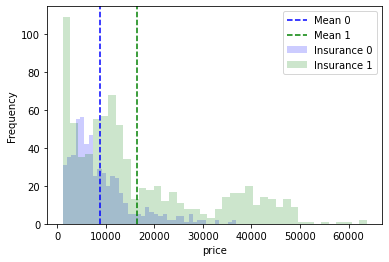

In [312]:
ins0.plot(kind='hist',bins=40,color='b',alpha=0.2,label='Insurance 0')
ins1.plot(kind='hist',bins=40,color='g',alpha=0.2,label='Insurance 1')

plt.axvline(ins0.mean(), color='b',linestyle='--',label='Mean 0')
plt.axvline(ins1.mean(), color='g',linestyle='--',label='Mean 1')

plt.xlabel('price')
plt.legend();

True mean distributions with bootstrap, and the difference:

In [170]:
seed(1)
bs0 = pd.DataFrame({'ave': [ins0.sample(ins0.shape[0],replace=True).mean() for i in range(n)]})
bs1 = pd.DataFrame({'ave': [ins1.sample(ins1.shape[0],replace=True).mean() for i in range(n)]})

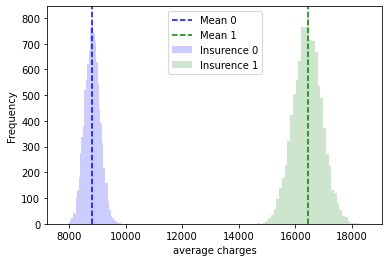

In [176]:
bs0.ave.plot(kind='hist',bins=40,color='b',alpha=0.2,label='Insurence 0')
bs1.ave.plot(kind='hist',bins=40,color='g',alpha=0.2,label='Insurence 1')

plt.axvline(bs0.ave.mean(), color='b',linestyle='--',label='Mean 0')
plt.axvline(bs1.ave.mean(), color='g',linestyle='--',label='Mean 1')

plt.xlabel('average charges')
plt.legend(loc="upper center");

m= -7607.959696643077 s= 569.7599676104787 m/s= -13.35


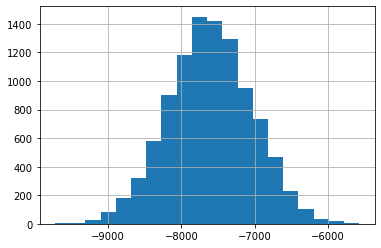

In [334]:
dm = bs0.ave - bs1.ave
dm.hist(bins=20)

print("m=",dm.mean(),"s=",dm.std(),"m/s=",round(dm.mean()/dm.std(),2))

Wow, so far away the zero! Now back to the questions. Let's calculate t statistics by hand using the formulae above:

In [317]:
n0 = ins0.shape[0]
n1 = ins1.shape[0]
print("Events in the samples: ",n0,n1)

m0 = ins0.mean()
m1 = ins1.mean()
print("Means: ",round(m0,2),round(m1,2)," Diffrence=",round(m0-m1,2))

s0 = ins0.std()
s1 = ins1.std()
print("Standard deviations: ",round(s0,2),round(s1,2))

Events in the samples:  555 783
Means:  8821.42 16423.93  Diffrence= -7602.51
Standard deviations:  6446.51 14045.93


In [318]:
s12 = (n0-1)*s0**2 + (n1-1)*s1**2
s12 /= n0 + n1 -2
s12 = np.sqrt(s12)

print("Pooled standard deviation =", round(s12,2))

Pooled standard deviation = 11520.03


In [323]:
denom = s12*np.sqrt(1/n0 + 1/n1)

t_stat = (m0 - m1)/denom

print("test statistics, t= ",round(t_stat,2))

test statistics, t=  -11.89


In [338]:
print("p-value=",1-t.cdf(0,n0 + n1 -2,m0-m1,denom))

p-value= 0.0


Now, calculations using the ttest_ind function from the scipy.stats library:

In [234]:
from scipy.stats import ttest_ind

ttest_ind(ins0,ins1)

Ttest_indResult(statistic=-11.893299030876712, pvalue=4.461230231620717e-31)

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ True, there's no equivalent function for the z-test. But the z-test is the t-test for large number of degrees of freedom (for dof > 30 the t-statistics becomes the normal statistics), so one can simply use the ttest_ind function. Or calculate by hand using the normal distribution.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test